In [83]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scipy.io as si
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from matplotlib_venn import venn3, venn3_circles

In [75]:
# Directory of CD3+ T cells single cell data
scrnaseq_dir = '/home/louiscam/projects/gpcr/data/bulk_rnaseq/cd3_t_cells/'
# Saving directory
saving_dir = '/home/louiscam/projects/gpcr/save/figures/'

### Load TCR and adhesome genes

In [77]:
# TCR genes
tcr_chr_loci = pickle.load(open(saving_dir+'tcr_chr_loci.pkl', 'rb'))
all_tcr_genes = tcr_chr_loci['gene'].unique()
print('Total number of TCR genes = '+str(len(all_tcr_genes)))

Total number of TCR genes = 90


In [78]:
# Adhesome genes
adhesome_chr_loci = pickle.load(open(saving_dir+'adhesome_chr_loci.pkl','rb'))
all_adhesome_genes = adhesome_chr_loci['gene'].unique()
print('Total number of adhesome genes = '+str(len(all_adhesome_genes)))

Total number of adhesome genes = 222


### Load data

In [42]:
# Load data
cell_barcodes = pd.read_csv(scrnaseq_dir+'GSE110686_tils20+32_barcodes.tsv', header=None, index_col=None, sep='\t')
cell_barcodes.columns = ['barcode']
gene_list = pd.read_csv(scrnaseq_dir+'GSE110686_tils20+32_genes.tsv', header=None, index_col=None, sep='\t')
gene_list.columns = ['ensembl_id', 'hgnc_id']
raw_data = si.mmread(scrnaseq_dir+'GSE110686_tils20+32_matrix.mtx')

In [43]:
# Create dense dataframe
raw_data_dense = raw_data.todense()
raw_data_dense = pd.DataFrame(raw_data_dense, index=gene_list['hgnc_id'], columns=cell_barcodes['barcode'])
raw_data_dense = raw_data_dense.T

In [44]:
# Sum duplicated column (same HGNC gene symbol)
raw_data_dense = raw_data_dense.groupby(level=0, axis=1).sum()

In [45]:
# Store in annotated data format
# Data
X = raw_data_dense
# Metadata on observations
obs = pd.DataFrame({'cell_id': raw_data_dense.index.values,
                    'batch': cell_barcodes['barcode'].str.split('-', expand=True)[1]})
obs = obs.set_index('cell_id')
# Metadata on genes
var = pd.DataFrame({'hgnc_id': raw_data_dense.columns.values})
var = var.set_index('hgnc_id')
# Store in anndata
adata = ad.AnnData(X, obs, var, dtype='int64')
adata

AnnData object with n_obs × n_vars = 6311 × 33660
    obs: 'batch'

In [46]:
# Drop batch number 3 (there is batch effect if we leave it, based on the analysis below)
# Batch 3 corresponds to the second patient in the experiment, see the GSE110686_series_matrix.txt file
adata = adata[(adata.obs['batch'] != '3'),:]
adata

View of AnnData object with n_obs × n_vars = 5174 × 33660
    obs: 'batch'

### Process data

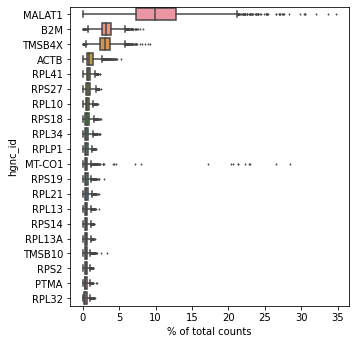

In [47]:
# Show those genes that yield the highest fraction of counts in each single cell, across all cells
sc.pl.highest_expr_genes(adata, n_top=20, )

In [48]:
# Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=0)

In [49]:
adata.shape

(5165, 33660)

/home/louiscam/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'batch' as categorical


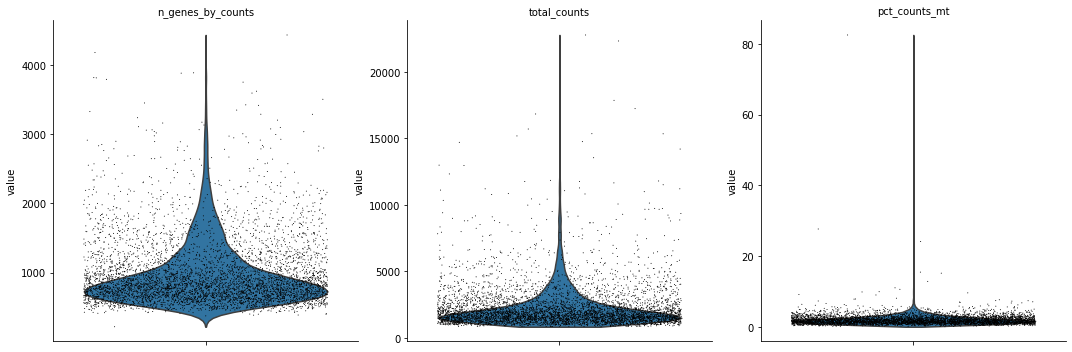

In [50]:
# High proportions of mitochondrial genes are indicative of poor-quality cells 
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

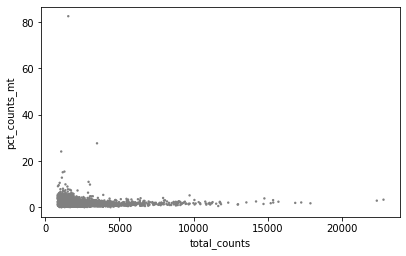

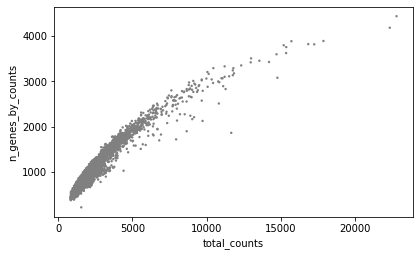

In [51]:
# Remove cells that have too many mitochondrial genes expressed or too many total counts
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
adata = adata[adata.obs.n_genes_by_counts < 3000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [52]:
# Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell
sc.pp.normalize_total(adata, target_sum=1e4)

/home/louiscam/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [53]:
# Log-transform the data
sc.pp.log1p(adata)

### Visualization

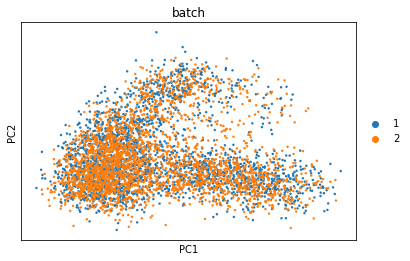

In [54]:
# Reduce the dimensionality of the data by running principal component analysis (PCA)
sc.tl.pca(adata, svd_solver='arpack')
# Scatter plot in the PCA coordinates (for visualization only)
sc.pl.pca(adata, color='batch')

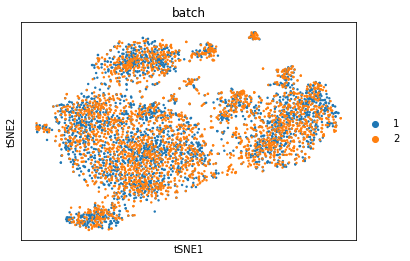

In [55]:
# Reduce the dimensionality of the data by running tSNE
sc.tl.tsne(adata)
# Scatter plot in the tSNE coordinates (for visualization only)
sc.pl.tsne(adata, color='batch')

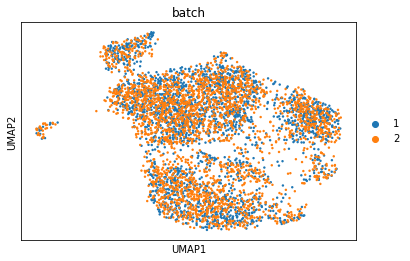

In [56]:
# Reduce the dimensionality of the data by running UMAP
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
# Scatter plot in the UMAP coordinates (for visualization only)
sc.pl.umap(adata, color='batch')

### Cluster genes

In [57]:
# Create scRNAseq dataframe
scrnaseq_df = pd.DataFrame(adata.X, index=adata.obs_names, columns = adata.var_names)
#pickle.dump(scrnaseq_df, open(scrnaseq_dir+'processed_scrnaseq_df', 'wb'))

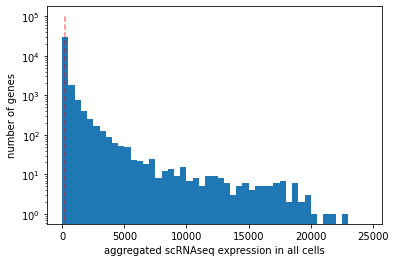

In [117]:
# Display cumulative expression of genes across all cells
scrnaseq_df = pickle.load(open(scrnaseq_dir+'processed_scrnaseq_df', 'rb'))
threshold = 200
plt.figure()
plt.hist(scrnaseq_df.sum(axis=0).values, bins=np.arange(0,25000, 500))
plt.vlines(x=threshold, ymin=0, ymax=1e5, color='red', linestyle='dashed', alpha=0.5)
plt.yscale('log')
plt.xlabel('aggregated scRNAseq expression in all cells')
plt.ylabel('number of genes')
plt.show()

In [118]:
# Define active and inactive genes based on thresold on aggregated expression
aggregated_per_gene = scrnaseq_df.sum(axis=0).reset_index(name='sum')
all_active_genes = aggregated_per_gene[aggregated_per_gene['sum']>threshold]['hgnc_id']
all_inactive_genes = aggregated_per_gene[aggregated_per_gene['sum']<=threshold]['hgnc_id']
print('Total number of active genes = '+str(len(all_active_genes)))
print('Total number of inactive genes = '+str(len(all_inactive_genes)))

Total number of active genes = 6935
Total number of inactive genes = 26725


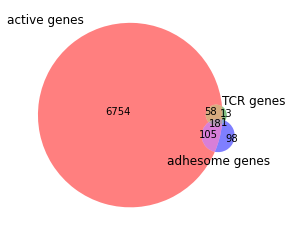

In [114]:
# Intersect active genes with adhesome genes and TCR genes
venn3(subsets = (set(all_active_genes), set(all_tcr_genes), set(all_adhesome_genes)), 
      set_labels = ('active genes', 'TCR genes', 'adhesome genes'), alpha = 0.5);

In [115]:
# Save active and inactive adhesome and TCR genes in CD3+ T cells
active_adhesome_genes_cd3t = np.array(list(set(all_active_genes).intersection(set(all_adhesome_genes))))
active_tcr_genes_cd3t = np.array(list(set(all_active_genes).intersection(set(all_tcr_genes))))
pickle.dump(all_active_genes, open(saving_dir+'all_active_genes_cd3t.pkl', 'wb'))
pickle.dump(active_adhesome_genes_cd3t, open(saving_dir+'active_adhesome_genes_cd3t.pkl', 'wb'))
pickle.dump(active_tcr_genes_cd3t, open(saving_dir+'active_tcr_genes_cd3t.pkl', 'wb'))

In [116]:
# Update adata object
adata.var.loc[:,'cluster'] = adata.var.index.isin(all_active_genes).astype(int)